In [1]:
### Part 01. Load packages and libs

In [2]:
import os
import time
import warnings
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.cuda.empty_cache()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

warnings.filterwarnings("ignore")

c:\Users\minht\anaconda3\envs\pydl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\minht\anaconda3\envs\pydl\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
### Part 02. Writing a custom dataset for Blood Cell Segmemtation dataset, write data loader to load data for train model

In [4]:
TRAIN_IMG_DIR = "datasets/kvasir_v1/train/images"
TRAIN_MASK_DIR = "datasets/kvasir_v1/train/masks"
VAL_IMG_DIR = "datasets/kvasir_v1/test/images"
VAL_MASK_DIR = "datasets/kvasir_v1/test/masks"

In [5]:
class BloodCellDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None) -> None:
        super(BloodCellDataset, self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(
            self.mask_dir, self.images[index])

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),
                        dtype=np.float32)
        # mask[mask == 255.0] = 1.0
        mask = np.where(mask > 155.0, 1.0, 0.0)

        if self.transform is not None:
            augemantations = self.transform(image=image, mask=mask)
            image = augemantations['image']
            mask = augemantations['mask']
        return image, mask

In [6]:
def get_data_loaders(
        train_dir, train_mask_dir, val_dir, val_maskdir, batch_size,
        train_transform, val_transform):

    train_ds = BloodCellDataset(
        image_dir=train_dir, mask_dir=train_mask_dir,
        transform=train_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = BloodCellDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [7]:
train_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [8]:
BATCH_SIZE = 6

train_loader, val_loader = get_data_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms
)

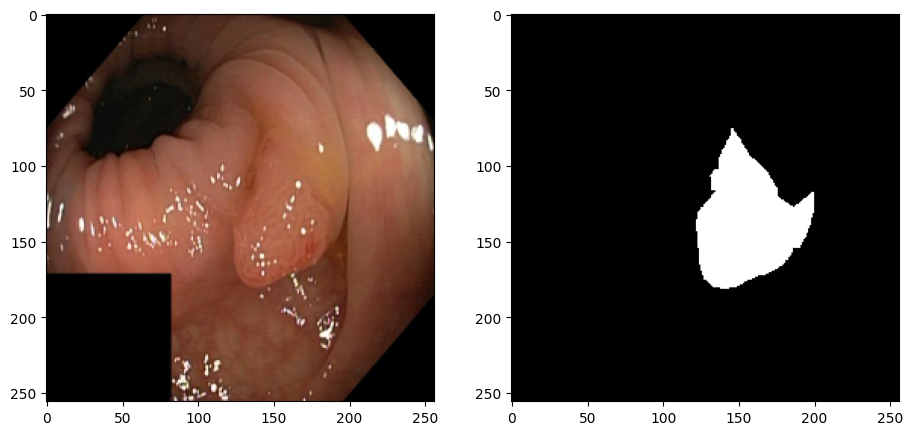

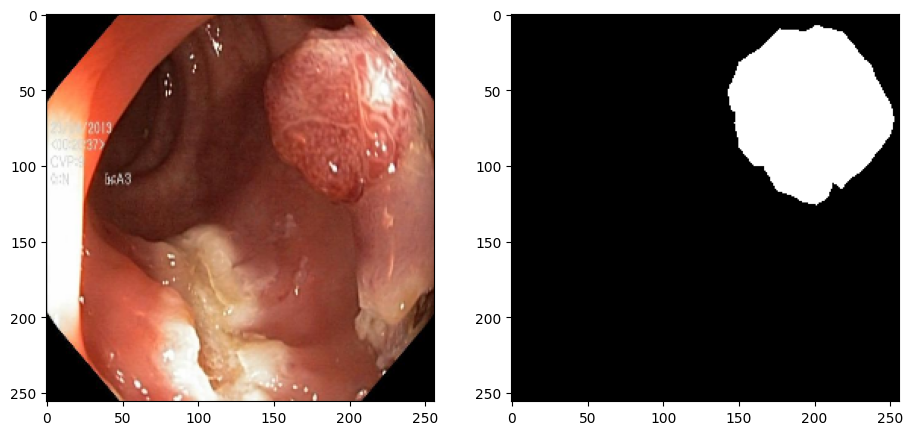

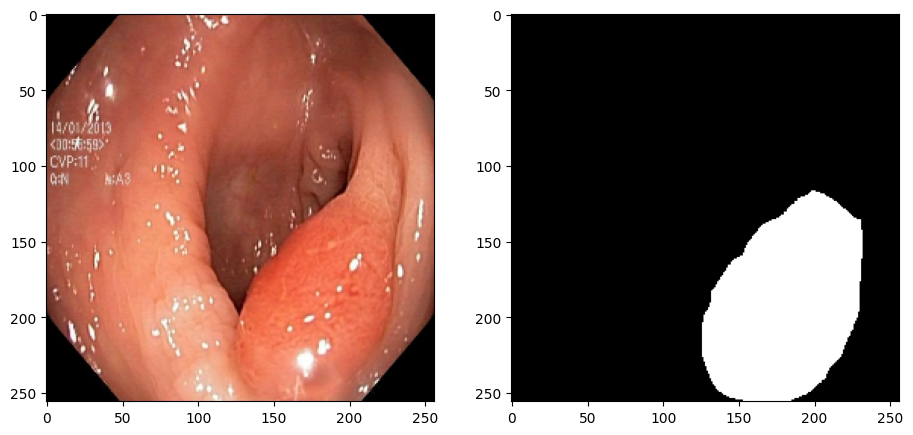

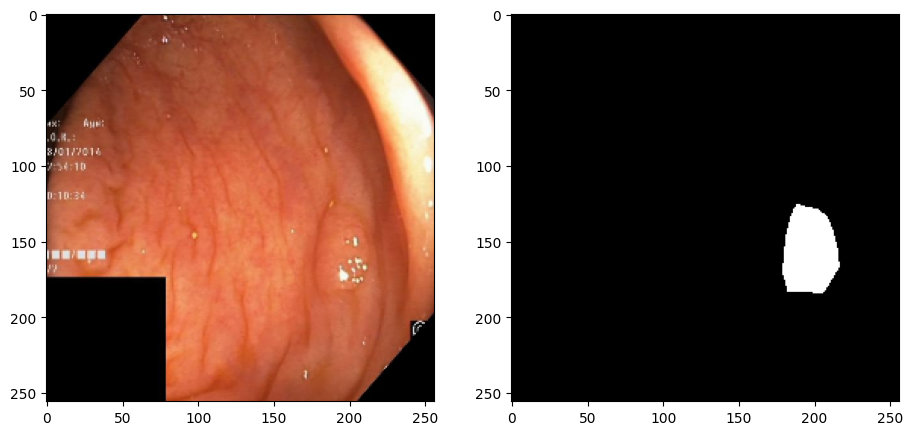

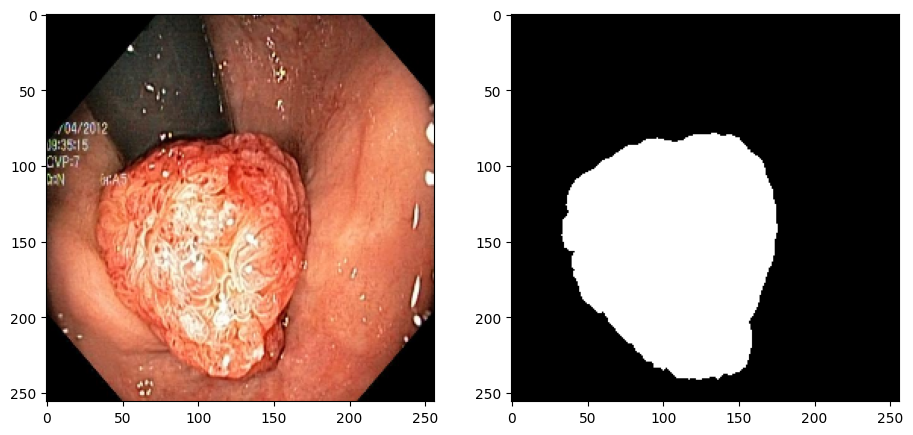

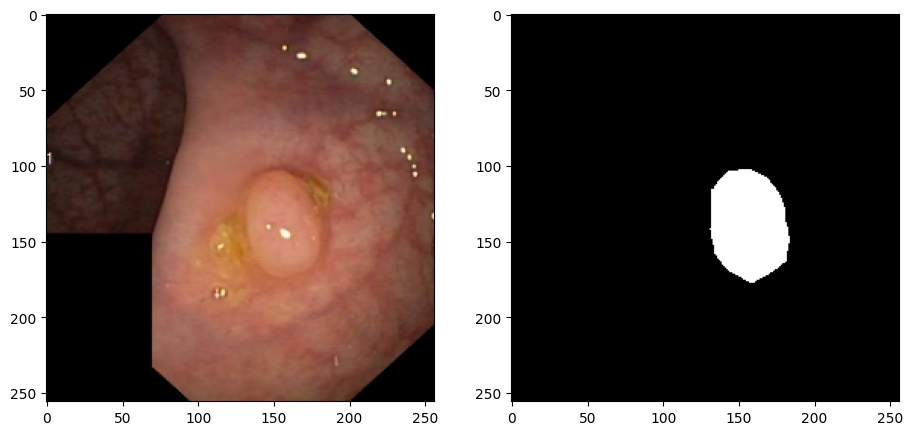

In [9]:
def show_transformed(data_loader):
    batch = next(iter(data_loader))
    images, labels = batch

    for img, mask in zip(images, labels):
        plt.figure(figsize=(11, 11))

        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(img, (1, 2, 0)))

        plt.subplot(1, 2, 2)
        # plt.imshow(mask.reshape(mask.shape[0], mask.shape[1], 1))
        plt.imshow(mask, cmap="gray")


show_transformed(val_loader)

In [10]:
train_loader.dataset[0][0].shape
train_loader.dataset[0][1].shape

torch.Size([256, 256])

In [11]:
class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               padding=1)  # 3 channels for RGB
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(
            64, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)

        return x

In [12]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_losss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        BCE = self.bce_losss(inputs, targets)
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(
            inputs.sum() + targets.sum() + smooth)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE


class IOU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)
        return IoU

In [13]:
model = FCN(num_classes=1).to(DEVICE)
loss_fn = DiceBCELoss()

iou_fn = IOU()
scaler = torch.cuda.amp.GradScaler()
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_iou = []
train_loss = []
train_dice = []

def save_checkpoint(state, filename="model.pth.tar"):
    print("=> Saving checkpoint")
    # torch.save(state, filename)

In [14]:
model

FCN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [15]:
print(model)

FCN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [16]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
            Conv2d-2        [-1, 128, 256, 256]          73,856
            Conv2d-3        [-1, 256, 256, 256]         295,168
   ConvTranspose2d-4        [-1, 128, 256, 256]         295,040
   ConvTranspose2d-5         [-1, 64, 256, 256]          73,792
   ConvTranspose2d-6          [-1, 1, 256, 256]             577
Total params: 740,225
Trainable params: 740,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 320.50
Params size (MB): 2.82
Estimated Total Size (MB): 324.07
----------------------------------------------------------------


In [17]:
start_time = time.time()

# let's train it just for 2 epochs
NUM_EPOCHS = 22

for epoch in range(NUM_EPOCHS):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}")

    iterations = 0
    iter_loss = 0.0
    iter_iou = 0.0

    batch_loop = tqdm(train_loader)
    for batch_idx, (data, targets) in enumerate(batch_loop):

        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            iou = iou_fn(predictions, targets)

            iter_loss += loss.item()
            iter_iou += iou.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        iterations += 1
        batch_loop.set_postfix(diceloss=loss.item(), iou=iou.item())

    train_loss.append(iter_loss / iterations)
    train_iou.append(iter_iou / iterations)
    # print(
    #     f"Epoch: {epoch+1}/{NUM_EPOCHS}, Training loss: {round(train_loss[-1] , 3)}")
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, IoU score: {iter_iou / iterations}")

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    # save_checkpoint(checkpoint)

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    # print(
    #     f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    # )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Total num_correct/num_pixels: {num_correct}/{num_pixels} => {num_correct/num_pixels}"
    )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Dice score: {dice_score / len(val_loader)}")
    train_dice.append(dice_score / len(val_loader))
    model.train()

print("done ..")

end_time = time.time()
training_time = end_time - start_time
print(
    f"The training time of the Fully Convolutional Network (FCN) model is: {training_time:.2f} seconds")

Epoch: 1/22


100%|██████████| 134/134 [36:35<00:00, 16.39s/it, diceloss=1.16, iou=0.192] 


Epoch: 1/22, IoU score: 0.16937828600517849
Epoch: 1/22, Total num_correct/num_pixels: 9361560/13107200 => 0.7142303586006165
Epoch: 1/22, Dice score: 0.4011085381811529
Epoch: 2/22


100%|██████████| 134/134 [38:38<00:00, 17.31s/it, diceloss=1.01, iou=0.28]  


Epoch: 2/22, IoU score: 0.18782984865690344
Epoch: 2/22, Total num_correct/num_pixels: 9575079/13107200 => 0.7305205464363098
Epoch: 2/22, Dice score: 0.40369278021296434
Epoch: 3/22


100%|██████████| 134/134 [38:57<00:00, 17.44s/it, diceloss=1.08, iou=0.222] 


Epoch: 3/22, IoU score: 0.19238192376805774
Epoch: 3/22, Total num_correct/num_pixels: 10159535/13107200 => 0.7751110196113586
Epoch: 3/22, Dice score: 0.3869033085221279
Epoch: 4/22


100%|██████████| 134/134 [26:30<00:00, 11.87s/it, diceloss=1, iou=0.157]    


Epoch: 4/22, IoU score: 0.19867874615227998
Epoch: 4/22, Total num_correct/num_pixels: 10370924/13107200 => 0.7912387251853943
Epoch: 4/22, Dice score: 0.3773905671432334
Epoch: 5/22


100%|██████████| 134/134 [23:56<00:00, 10.72s/it, diceloss=0.836, iou=0.304]


Epoch: 5/22, IoU score: 0.19837684039749318
Epoch: 5/22, Total num_correct/num_pixels: 10445200/13107200 => 0.796905517578125
Epoch: 5/22, Dice score: 0.37295378029105125
Epoch: 6/22


100%|██████████| 134/134 [17:22<00:00,  7.78s/it, diceloss=0.873, iou=0.246]


Epoch: 6/22, IoU score: 0.19872380248201427
Epoch: 6/22, Total num_correct/num_pixels: 10548694/13107200 => 0.8048014640808105
Epoch: 6/22, Dice score: 0.36185278102469287
Epoch: 7/22


100%|██████████| 134/134 [15:57<00:00,  7.15s/it, diceloss=0.826, iou=0.272]


Epoch: 7/22, IoU score: 0.20238586598590239
Epoch: 7/22, Total num_correct/num_pixels: 10235017/13107200 => 0.7808698415756226
Epoch: 7/22, Dice score: 0.3952863300023698
Epoch: 8/22


100%|██████████| 134/134 [16:09<00:00,  7.24s/it, diceloss=1.04, iou=0.108] 


Epoch: 8/22, IoU score: 0.20247881787259187
Epoch: 8/22, Total num_correct/num_pixels: 10656475/13107200 => 0.8130245208740234
Epoch: 8/22, Dice score: 0.35006396579206517
Epoch: 9/22


100%|██████████| 134/134 [15:58<00:00,  7.15s/it, diceloss=0.901, iou=0.286]


Epoch: 9/22, IoU score: 0.2024899828456231
Epoch: 9/22, Total num_correct/num_pixels: 10207642/13107200 => 0.7787812948226929
Epoch: 9/22, Dice score: 0.3987708930311314
Epoch: 10/22


100%|██████████| 134/134 [16:09<00:00,  7.24s/it, diceloss=1.14, iou=0.238] 


Epoch: 10/22, IoU score: 0.20455159163519518
Epoch: 10/22, Total num_correct/num_pixels: 10642718/13107200 => 0.8119749426841736
Epoch: 10/22, Dice score: 0.3638752809945878
Epoch: 11/22


100%|██████████| 134/134 [16:06<00:00,  7.21s/it, diceloss=1, iou=0.197]    


Epoch: 11/22, IoU score: 0.2062484751552788
Epoch: 11/22, Total num_correct/num_pixels: 10897180/13107200 => 0.8313888311386108
Epoch: 11/22, Dice score: 0.3086082107428534
Epoch: 12/22


100%|██████████| 134/134 [16:19<00:00,  7.31s/it, diceloss=1.19, iou=0.093] 


Epoch: 12/22, IoU score: 0.20783644592139258
Epoch: 12/22, Total num_correct/num_pixels: 10965094/13107200 => 0.8365702629089355
Epoch: 12/22, Dice score: 0.29947877732135636
Epoch: 13/22


100%|██████████| 134/134 [16:03<00:00,  7.19s/it, diceloss=1.17, iou=0.17]  


Epoch: 13/22, IoU score: 0.20604772020631762
Epoch: 13/22, Total num_correct/num_pixels: 10123505/13107200 => 0.7723621129989624
Epoch: 13/22, Dice score: 0.41293690022794494
Epoch: 14/22


100%|██████████| 134/134 [18:47<00:00,  8.41s/it, diceloss=0.868, iou=0.312]


Epoch: 14/22, IoU score: 0.208936639769531
Epoch: 14/22, Total num_correct/num_pixels: 10244911/13107200 => 0.7816246747970581
Epoch: 14/22, Dice score: 0.4186524966402686
Epoch: 15/22


100%|██████████| 134/134 [22:26<00:00, 10.05s/it, diceloss=1.19, iou=0.14]  


Epoch: 15/22, IoU score: 0.20859704283413602
Epoch: 15/22, Total num_correct/num_pixels: 10549614/13107200 => 0.804871678352356
Epoch: 15/22, Dice score: 0.3937919954442105
Epoch: 16/22


100%|██████████| 134/134 [23:14<00:00, 10.41s/it, diceloss=0.903, iou=0.287]


Epoch: 16/22, IoU score: 0.21106254915470507
Epoch: 16/22, Total num_correct/num_pixels: 10573555/13107200 => 0.806698203086853
Epoch: 16/22, Dice score: 0.3948694298241249
Epoch: 17/22


100%|██████████| 134/134 [18:50<00:00,  8.44s/it, diceloss=0.907, iou=0.237]


Epoch: 17/22, IoU score: 0.2136628912456
Epoch: 17/22, Total num_correct/num_pixels: 10649732/13107200 => 0.812510073184967
Epoch: 17/22, Dice score: 0.39755305919353456
Epoch: 18/22


100%|██████████| 134/134 [19:06<00:00,  8.56s/it, diceloss=1.01, iou=0.232] 


Epoch: 18/22, IoU score: 0.21369493480271368
Epoch: 18/22, Total num_correct/num_pixels: 10139926/13107200 => 0.7736149430274963
Epoch: 18/22, Dice score: 0.42357803091192425
Epoch: 19/22


100%|██████████| 134/134 [19:32<00:00,  8.75s/it, diceloss=1.27, iou=0.09]  


Epoch: 19/22, IoU score: 0.21561010837999742
Epoch: 19/22, Total num_correct/num_pixels: 10801151/13107200 => 0.8240624070167542
Epoch: 19/22, Dice score: 0.36977915932156047
Epoch: 20/22


100%|██████████| 134/134 [19:59<00:00,  8.95s/it, diceloss=0.981, iou=0.214]


Epoch: 20/22, IoU score: 0.21445676311850548
Epoch: 20/22, Total num_correct/num_pixels: 10176873/13107200 => 0.7764337658882141
Epoch: 20/22, Dice score: 0.4319361233689453
Epoch: 21/22


100%|██████████| 134/134 [17:35<00:00,  7.88s/it, diceloss=1.14, iou=0.114] 


Epoch: 21/22, IoU score: 0.21824665139637775
Epoch: 21/22, Total num_correct/num_pixels: 10622467/13107200 => 0.8104299306869507
Epoch: 21/22, Dice score: 0.39851799048695824
Epoch: 22/22


100%|██████████| 134/134 [22:56<00:00, 10.27s/it, diceloss=1, iou=0.209]    


Epoch: 22/22, IoU score: 0.22001949180640393
Epoch: 22/22, Total num_correct/num_pixels: 10897523/13107200 => 0.8314149975776672
Epoch: 22/22, Dice score: 0.3742227181997509
done ..
The training time of the Fully Convolutional Network (FCN) model is: 31126.46 seconds


In [18]:
print(train_loss)

[1.1364365655984452, 1.0786001597767445, 1.0737571040196205, 1.0602757930755615, 1.0581409931182861, 1.0547168148097708, 1.0515838038565508, 1.0533660156513327, 1.0495764026001317, 1.0489625886305054, 1.0447699485430078, 1.040884888439036, 1.0405539607823784, 1.03696938504034, 1.040554330864949, 1.0373947731594542, 1.0294079491451604, 1.0288744008363182, 1.0261011003558316, 1.0292087495326996, 1.0189269972381307, 1.0191095017675142]


In [19]:
print(train_iou)

[0.16937828600517849, 0.18782984865690344, 0.19238192376805774, 0.19867874615227998, 0.19837684039749318, 0.19872380248201427, 0.20238586598590239, 0.20247881787259187, 0.2024899828456231, 0.20455159163519518, 0.2062484751552788, 0.20783644592139258, 0.20604772020631762, 0.208936639769531, 0.20859704283413602, 0.21106254915470507, 0.2136628912456, 0.21369493480271368, 0.21561010837999742, 0.21445676311850548, 0.21824665139637775, 0.22001949180640393]


In [20]:
print(train_dice)

[tensor(0.4011, dtype=torch.float64), tensor(0.4037, dtype=torch.float64), tensor(0.3869, dtype=torch.float64), tensor(0.3774, dtype=torch.float64), tensor(0.3730, dtype=torch.float64), tensor(0.3619, dtype=torch.float64), tensor(0.3953, dtype=torch.float64), tensor(0.3501, dtype=torch.float64), tensor(0.3988, dtype=torch.float64), tensor(0.3639, dtype=torch.float64), tensor(0.3086, dtype=torch.float64), tensor(0.2995, dtype=torch.float64), tensor(0.4129, dtype=torch.float64), tensor(0.4187, dtype=torch.float64), tensor(0.3938, dtype=torch.float64), tensor(0.3949, dtype=torch.float64), tensor(0.3976, dtype=torch.float64), tensor(0.4236, dtype=torch.float64), tensor(0.3698, dtype=torch.float64), tensor(0.4319, dtype=torch.float64), tensor(0.3985, dtype=torch.float64), tensor(0.3742, dtype=torch.float64)]


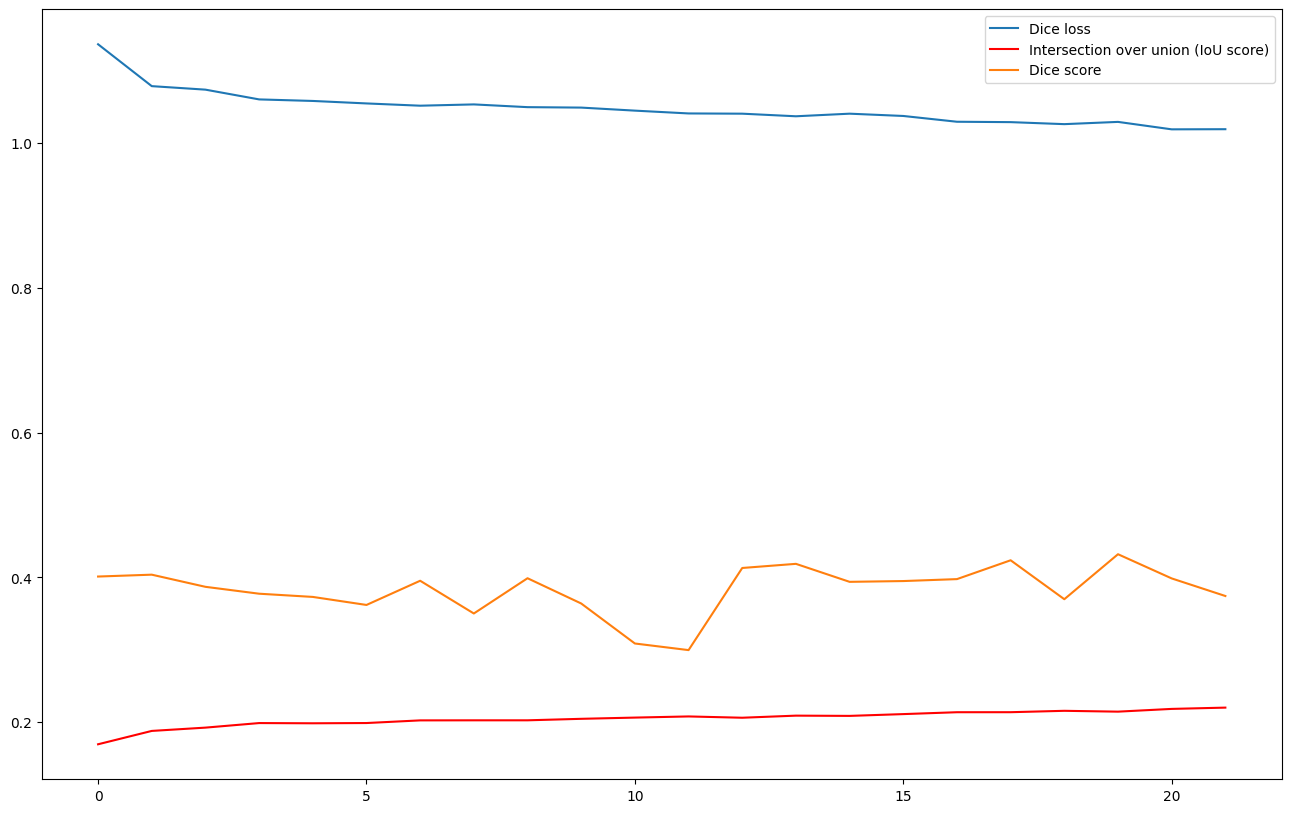

In [21]:
f = plt.figure(figsize=(16, 10))
plt.plot(train_loss, label='Dice loss')
# plt.plot(train_iou, label='Intersection over union (IoU score)')
plt.plot(train_iou, label='Intersection over union (IoU score)', color='red')
plt.plot(train_dice, label='Dice score')
plt.legend()
plt.show()

In [22]:
def test_model(model, val_loader, device):
    model.eval()
    dice_score = 0
    iou_metric = IOU()
    iou_score = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Testing"):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            dice_score += (2 * (preds_binary * y).sum()) / (
                (preds_binary + y).sum() + 1e-8
            )
            iou_score += iou_metric(preds_binary, y)

    avg_dice = dice_score / len(val_loader)
    avg_iou = iou_score / len(val_loader)

    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")

    return avg_dice, avg_iou


# Run the test function
avg_dice, avg_iou = test_model(model, val_loader, DEVICE)

Testing: 100%|██████████| 34/34 [02:12<00:00,  3.90s/it]

Average Dice Score: 0.3742
Average IoU Score: 0.1423


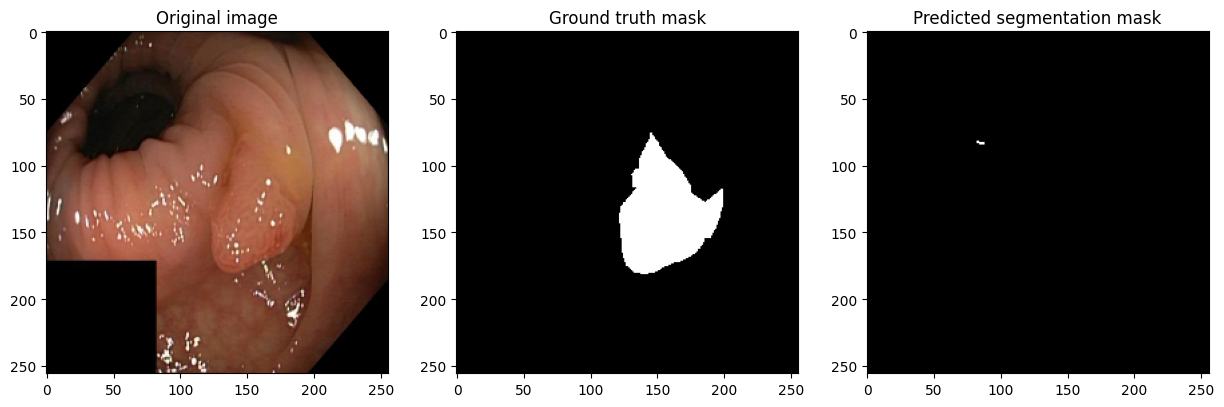

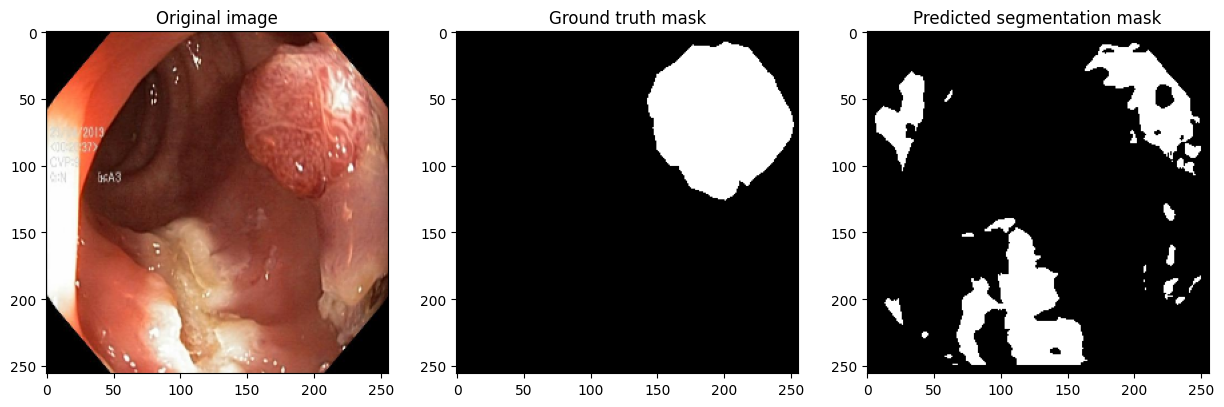

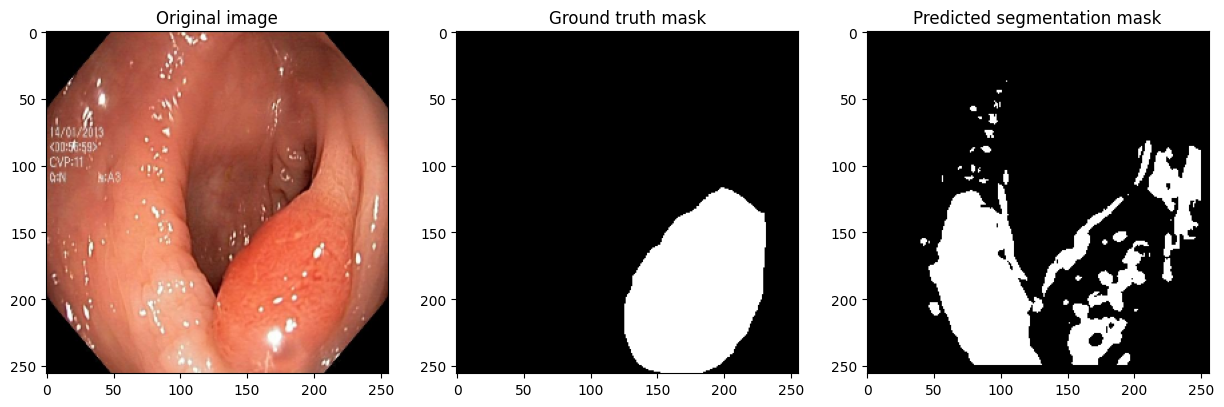

In [23]:
def visualize_predictions(model, val_loader, device, num_samples=3):
    model.eval()
    samples = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            for i in range(x.size(0)):
                if samples >= num_samples:
                    break

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.title("Original image")
                plt.imshow(np.transpose(x[i].cpu().numpy(), (1, 2, 0)))

                # Ground Truth
                plt.subplot(1, 3, 2)
                plt.title("Ground truth mask")
                plt.imshow(y[i].cpu().numpy().squeeze(), cmap="gray")

                # Predicted Mask
                plt.subplot(1, 3, 3)
                plt.title("Predicted segmentation mask")
                plt.imshow(preds_binary[i].cpu(
                ).numpy().squeeze(), cmap="gray")

                plt.show()
                samples += 1

            if samples >= num_samples:
                break


visualize_predictions(model, val_loader, DEVICE)

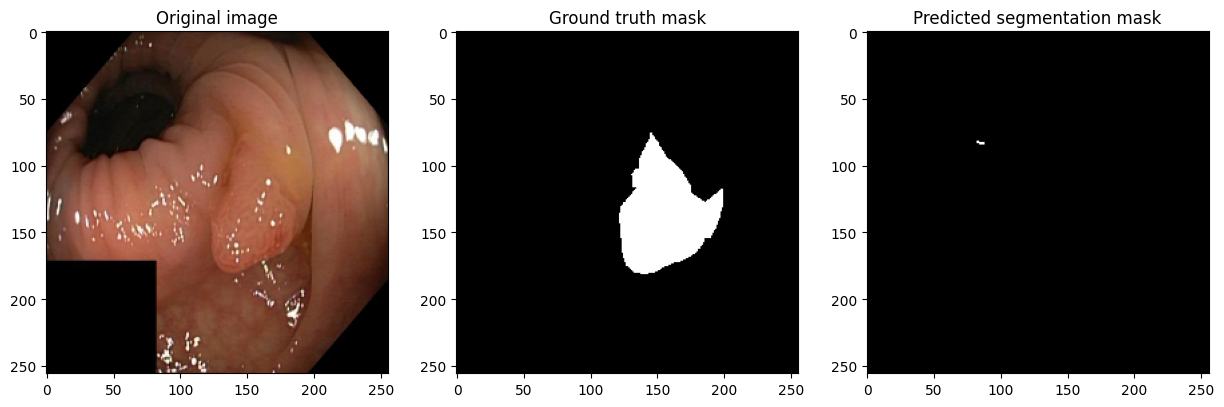

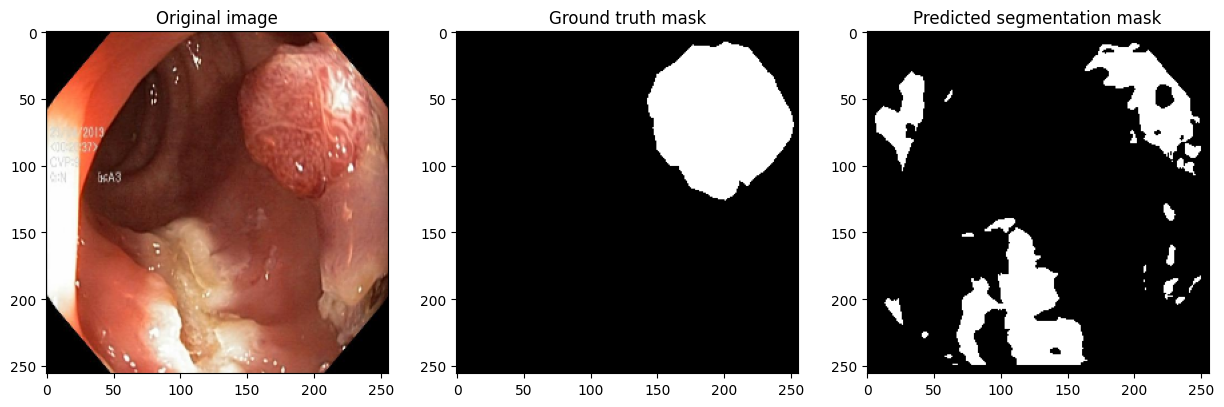

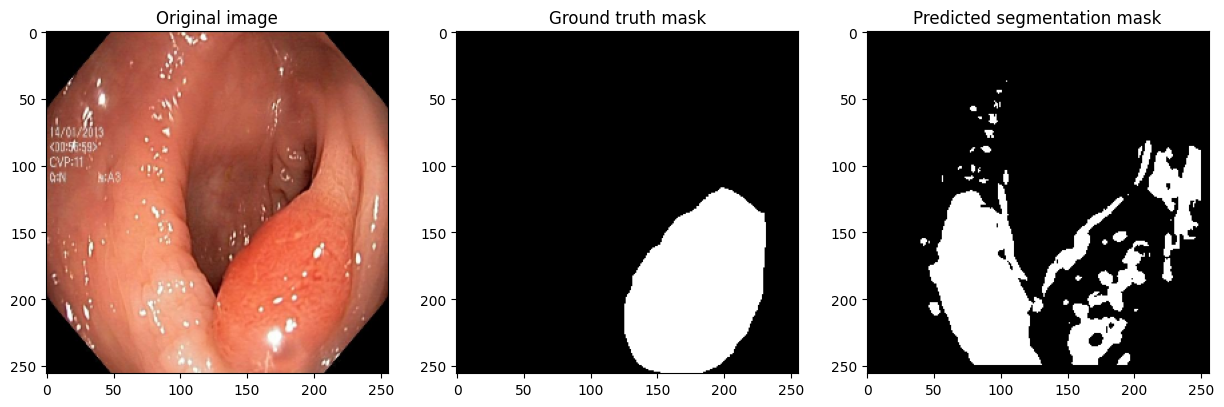

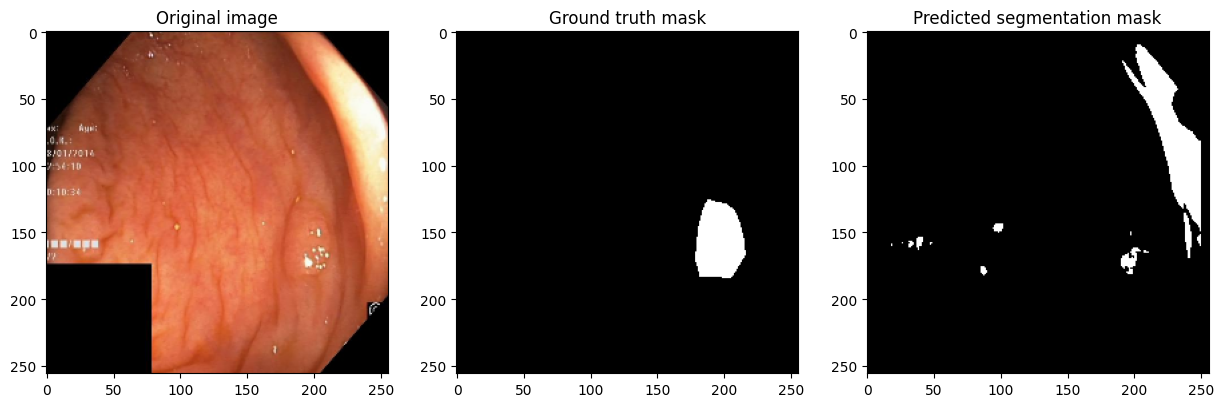

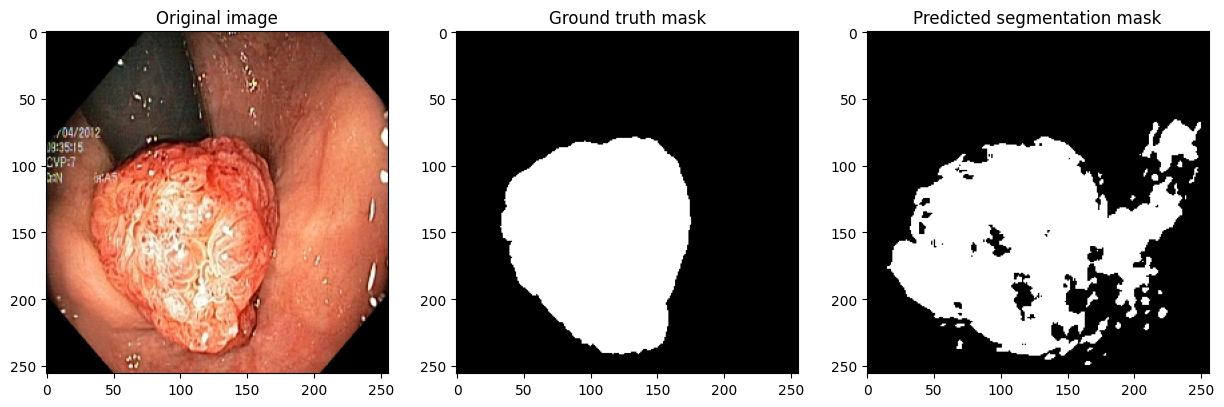

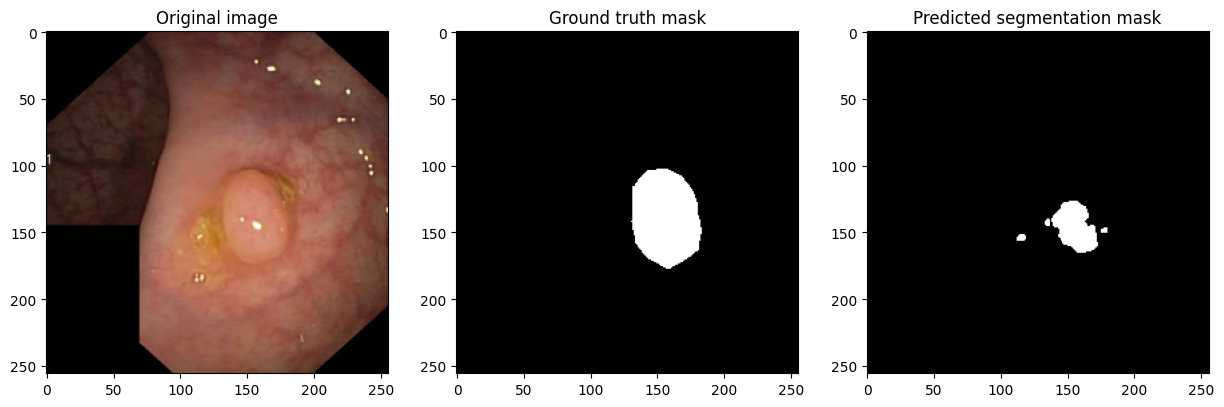

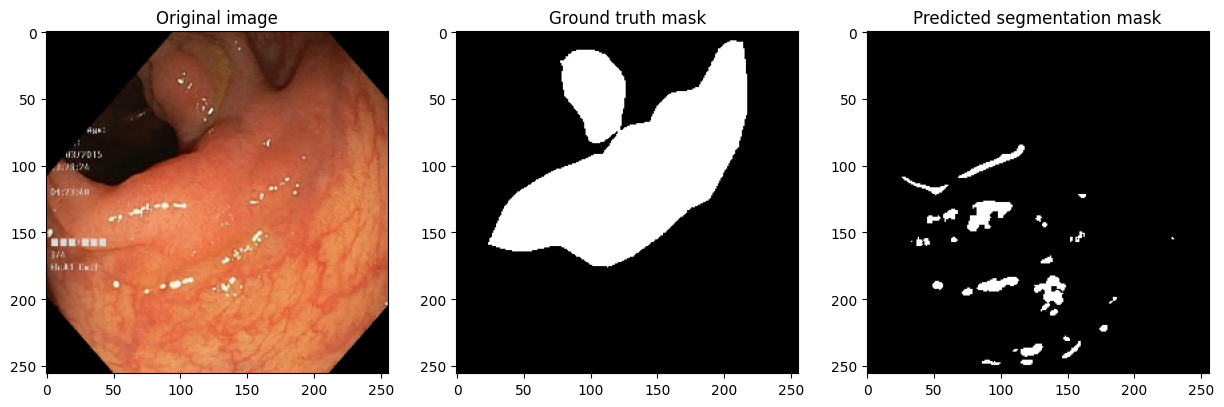

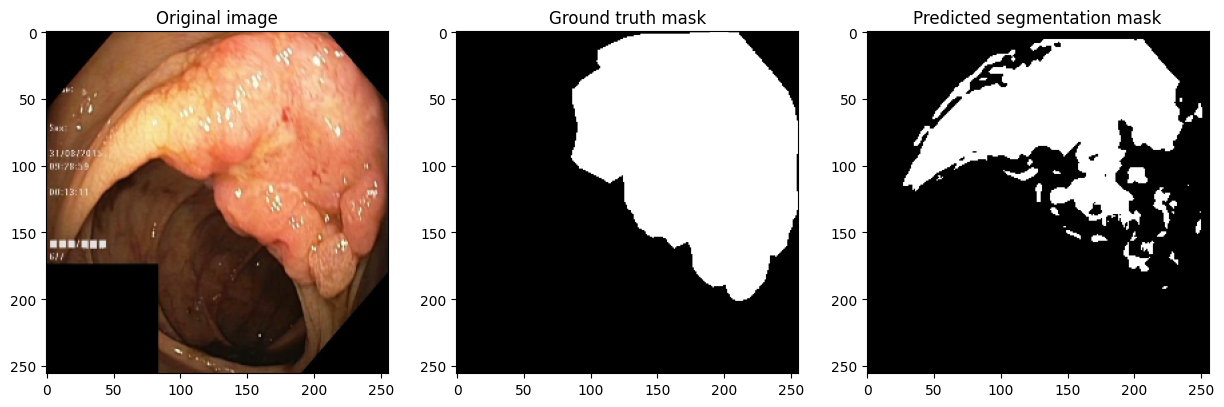

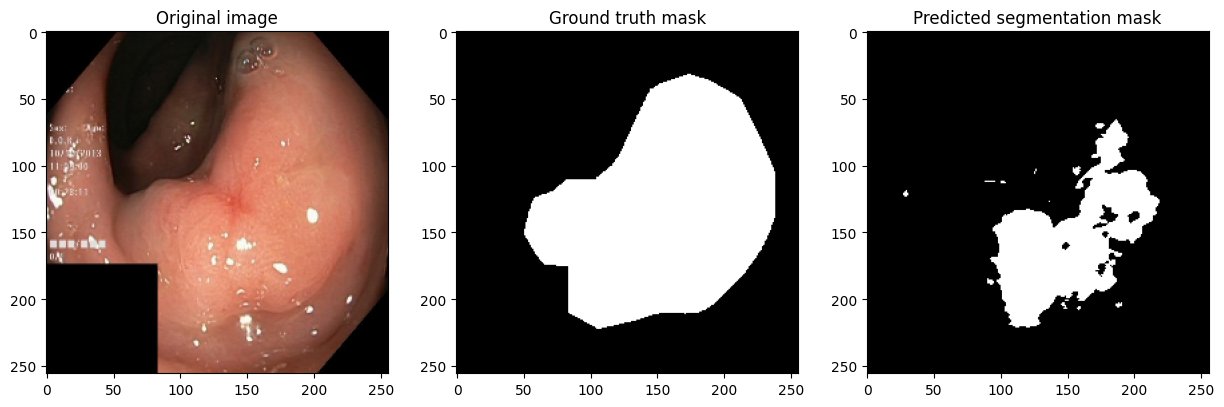

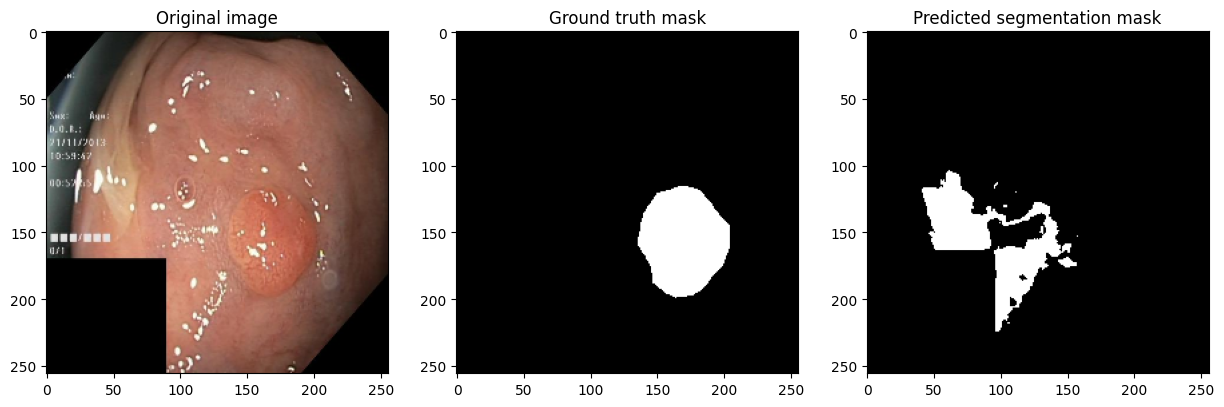

In [24]:
visualize_predictions(model, val_loader, DEVICE, num_samples=10)